# Does ND2 replicate the biology?

In [26]:
import napari
from macrohet import dataio, tile, tools, visualise, colours
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np
from macrohet.notify import send_sys_message as notify
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zarr

palette = colours.expanded_piyg
sns.set_theme(style = 'white')
sns.set(font='Nimbus Sans', style = 'white')

# Define a function to remove outliers using IQR
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]


In [14]:
os.getpid()

1219171

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
%%time
expt_ID = 'ND0002'
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 51 s, sys: 3.87 s, total: 54.9 s
Wall time: 1min 1s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0103K1F1P1R1,Ok,r01c03f01p01-ch1sk1fk1fl1.tiff,1,3,1,1,0,1,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.49+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
1,0103K1F1P1R2,Ok,r01c03f01p01-ch2sk1fk1fl1.tiff,1,3,1,1,0,2,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.723+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
2,0103K1F1P2R1,Ok,r01c03f01p02-ch1sk1fk1fl1.tiff,1,3,1,2,0,1,1,...,0,0.135468394,0,2023-11-30T17:22:10.067+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
3,0103K1F1P2R2,Ok,r01c03f01p02-ch2sk1fk1fl1.tiff,1,3,1,2,0,2,1,...,0,0.135468394,0,2023-11-30T17:22:10.287+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
4,0103K1F1P3R1,Ok,r01c03f01p03-ch1sk1fk1fl1.tiff,1,3,1,3,0,1,1,...,2E-06,0.135470405,0,2023-11-30T17:22:10.627+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388615,0612K150F9P1R2,Ok,r06c12f09p01-ch2sk150fk1fl1.tiff,6,12,9,1,149,2,1,...,-2E-06,0.1351538,268191.66,2023-12-03T20:06:16.08+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388616,0612K150F9P2R1,Ok,r06c12f09p02-ch1sk150fk1fl1.tiff,6,12,9,2,149,1,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.423+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388617,0612K150F9P2R2,Ok,r06c12f09p02-ch2sk150fk1fl1.tiff,6,12,9,2,149,2,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.657+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388618,0612K150F9P3R1,Ok,r06c12f09p03-ch1sk150fk1fl1.tiff,6,12,9,3,149,1,1,...,2E-06,0.135157794,268191.66,2023-12-03T20:06:17+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [5]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

### Define row and column of choice

In [6]:
acq_ID = row, column = (3, 4)

### Will use sum of image intensity over Z using slightly slower tiling procedure 
as this is what i did previously 

In [8]:
%%time
image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane='sum_proj', 
                             set_channel = 1,
                             )#tile.compile_mosaic(image_dir, metadata, row, column,).compute().compute()
images

CPU times: user 1.3 s, sys: 7.61 ms, total: 1.31 s
Wall time: 1.35 s


dask.array<astype, shape=(150, 1, 6048, 6048), dtype=uint16, chunksize=(1, 1, 2160, 2160), chunktype=numpy.ndarray>

### Iterate over each image and find expression of gfp

In [10]:
output_dir = '/mnt/SYNO/macrohet_syno/ND0002/results/whole_fov_macrophage_growth/'

In [11]:
gfp_df = pd.DataFrame({}, columns = assay_layout.index)
for acq_ID, data in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
    strain = data['Strain']
    compound = data['Compound']
    conc = data['Concentration']
    name = f'{strain, compound, conc}'
    row, column = acq_ID
    
    images = tile.compile_mosaic(image_dir, 
                         metadata, 
                         row, 
                         column, 
                         set_plane='sum_proj', 
                         set_channel = 2, # different channel enumeration this time round
                         )
    gfp_signals = []
    for t in tqdm(range(0,len(images)), leave = False):
        try:
            frame = images[t].compute().compute()
            gfp_signal = np.sum(frame)
        except Exception as e:
            print(f'Could not load frame {t} row, col {acq_ID}')
            print(e)
            gfp_signal = None
        gfp_signals.append(gfp_signal)
    gfp_acq_ID_df = pd.DataFrame({'Time': range(len(gfp_signals)), 'GFP_Signal': gfp_signals})
    gfp_acq_ID_df.to_csv(os.path.join(output_dir, f'GFP_signals_{acq_ID}.csv'))
    gfp_df[acq_ID] = gfp_signals
    output_dir = os.path.join(base_dir, 'results/whole_fov_macrophage_growth/raw_data')
    os.makedirs(output_dir, exist_ok=True)
    gfp_df.to_csv(os.path.join(output_dir, f'GFP_signals.csv'))

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Could not load frame 14 row, col (6, 3)
total size of new array must be unchanged
Could not load frame 97 row, col (6, 3)
list index out of range


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

# Plot

In [18]:
import warnings
import pandas as pd
# Disable the FutureWarning related to use_inf_as_na
warnings.simplefilter(action='ignore', category=FutureWarning)
with pd.option_context('mode.use_inf_as_na', True):
    pass 

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [20]:
fluo_scaling_factor = 1/1.55E10

In [21]:
output_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/results/whole_fov_macrophage_growth/'

### RD1 and WT

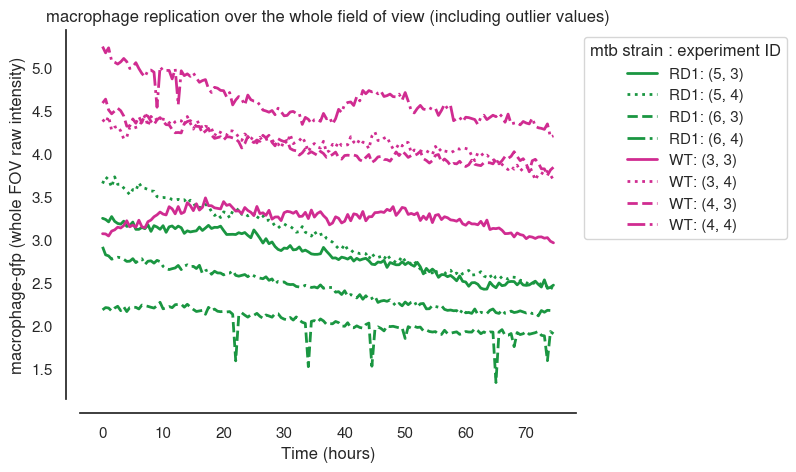

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[5]]  # RD1 and WT colors

# Iterate over conditions and assign line styles
for condition, color in zip(['RD1', 'WT'], colors):
    condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == condition)].index
    for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
        sns.lineplot(
            data=gfp_df.T.loc[index] * fluo_scaling_factor,
            label=f'{condition}: {index}',
            linewidth=2,
            color=color,
            linestyle=linestyle,
        )
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('macrophage-gfp (whole FOV raw intensity)')
plt.title('macrophage replication over the whole field of view (including outlier values)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_macrophage_growth_row_WT_RD1.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


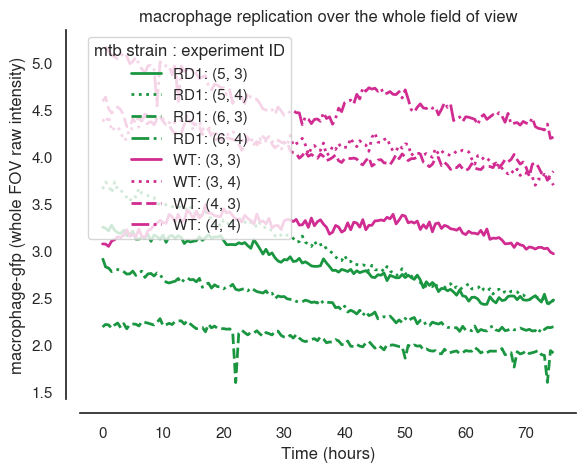

In [30]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[5]]  # RD1 and WT colors

# Iterate over conditions and assign line styles
for condition, color in zip(['RD1', 'WT'], colors):
    condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == condition)].index
    for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
        
        cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
        sns.lineplot(
            data=cleaned_series * fluo_scaling_factor,
            label=f'{condition}: {index}',
            linewidth=2,
            color=color,
            linestyle=linestyle,
        )
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('macrophage-gfp (whole FOV raw intensity)')
plt.title('macrophage replication over the whole field of view')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_cleaned_macrophage_growth_row_WT_RD1.png'), bbox_inches='tight', dpi=314)

plt.show()  # Display the plot

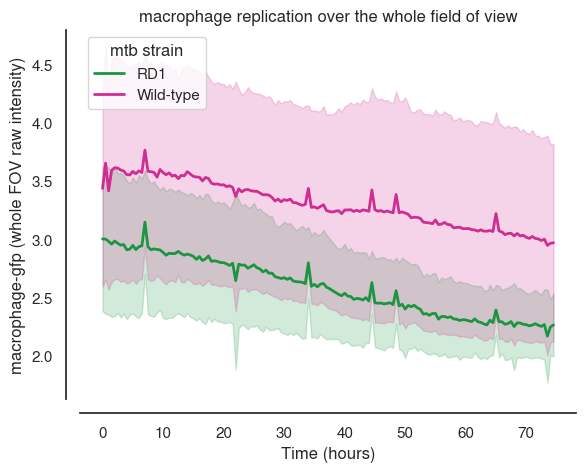

In [31]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[5]]  # RD1 and WT colors
cleaned_concat_series = []
# Iterate over conditions and assign line styles
for condition, color in zip(['RD1', 'WT'], colors):
    condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == condition)].index
    for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
        
        cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
        cleaned_concat_series.append(cleaned_series)
    concat_series = pd.concat(cleaned_concat_series)
    label = condition if condition == 'RD1' else 'Wild-type'
    sns.lineplot(
        data=concat_series * fluo_scaling_factor,
        label=label,#: {index}',
        linewidth=2,
        color=color,
        ci='sd',
        linestyle='-',
    )

# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('macrophage-gfp (whole FOV raw intensity)')
plt.title('macrophage replication over the whole field of view')
# plt.savefig(os.path.join(output_dir, 'whole_fov_cleaned_macrophage_growth_row_WT_RD1.png'), bbox_inches='tight', dpi=314)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'mtb strain')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_cleaned_combined_macrophage_growth_row_WT_RD1.png'), bbox_inches='tight', dpi=314)

plt.show()  # Display the plot

### Comparing Atbs

#### Add repeat number to assay layout

In [32]:
n = 0
labels = []
assay_layout['Technical repeat'] = 0

for (row, column), info in assay_layout.iterrows():
    strain = info['Strain']
    comp = info['Compound']
    conc = info['Concentration']
    ec_conc = info['ConcentrationEC']
    label = f'{strain},{comp},{ec_conc},{conc}'     
    if label not in labels:
        n =1
        assay_layout.loc[(row, column), 'Technical repeat'] = n
        labels.append(label)
    else:
        n = labels.count(label)+1
        assay_layout.loc[(row, column), 'Technical repeat'] = n
        labels.append(label)

In [33]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

### mapping colours to previous

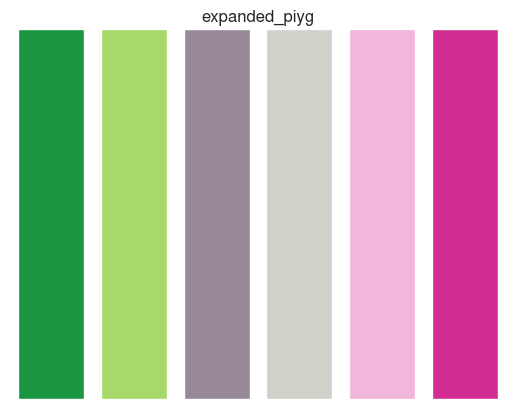

[(0, '#1a9641'),
 (1, '#a6d96a'),
 (2, '#978897'),
 (3, '#d1d1ca'),
 (4, '#f1b6da'),
 (5, '#d02c91')]

In [34]:
### mapping colours to be teh same as last time
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg')
[(n, i) for n, i in enumerate(colours.expanded_piyg)]

In [35]:
colour_map_dict = {'RD1':colours.expanded_piyg[0], 
                   'WT': colours.expanded_piyg[1], 
                   'PZA': colours.expanded_piyg[2], 
                   'RIF': colours.expanded_piyg[3], 
                   'INH': colours.expanded_piyg[4], 
                   'BDQ': colours.expanded_piyg[5], 
                   'UNI': '#000000'}

### Plot different atb conditions per repeat

/tmp/ipykernel_1219171/2769244856.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/2769244856.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/2769244856.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/2769244856.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


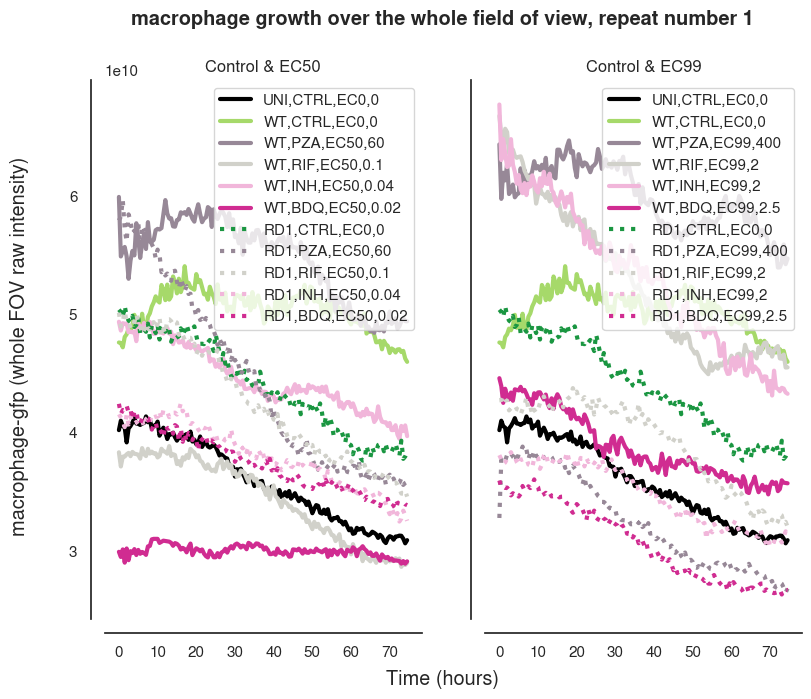

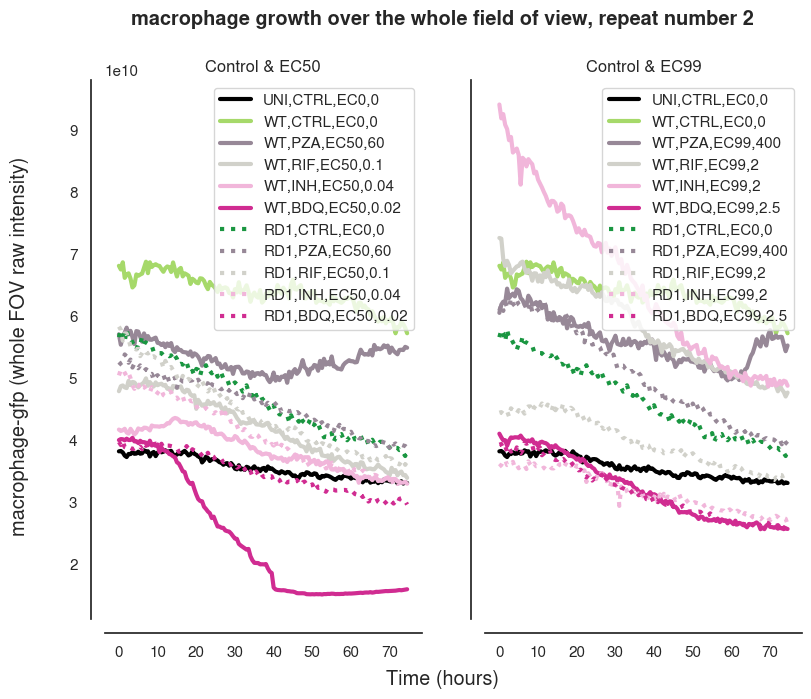

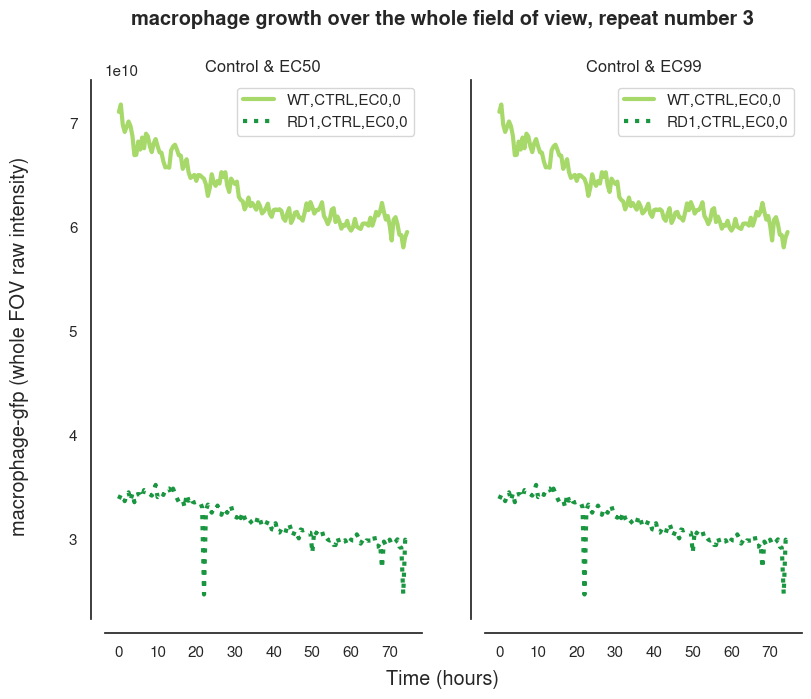

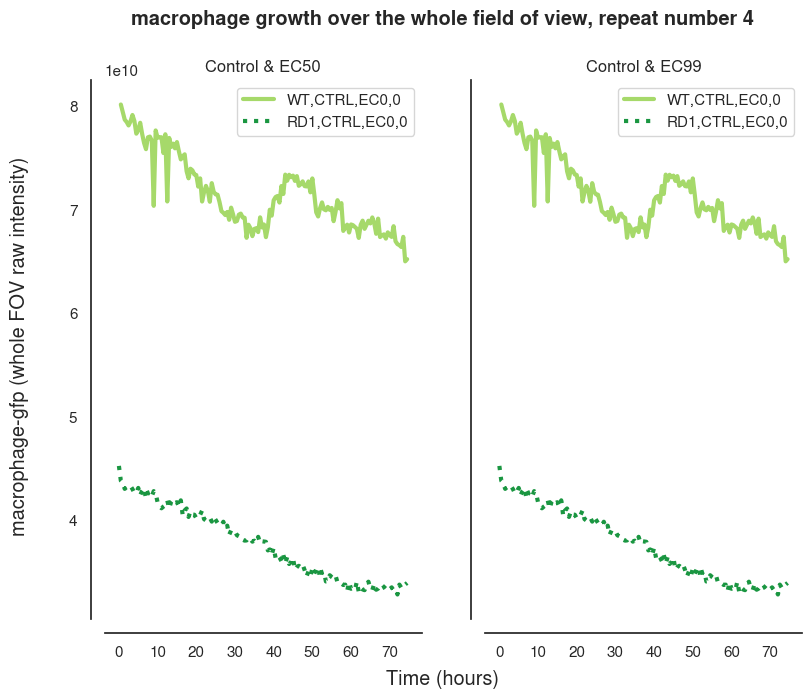

In [36]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
    x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
    plt.suptitle(f'macrophage growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_wRD1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1219171/549332672.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/549332672.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/549332672.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/549332672.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


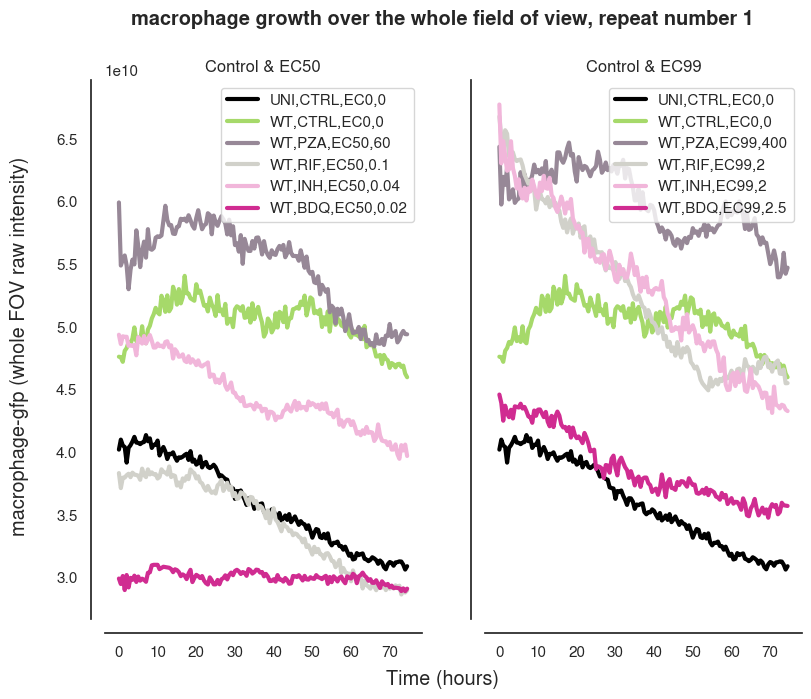

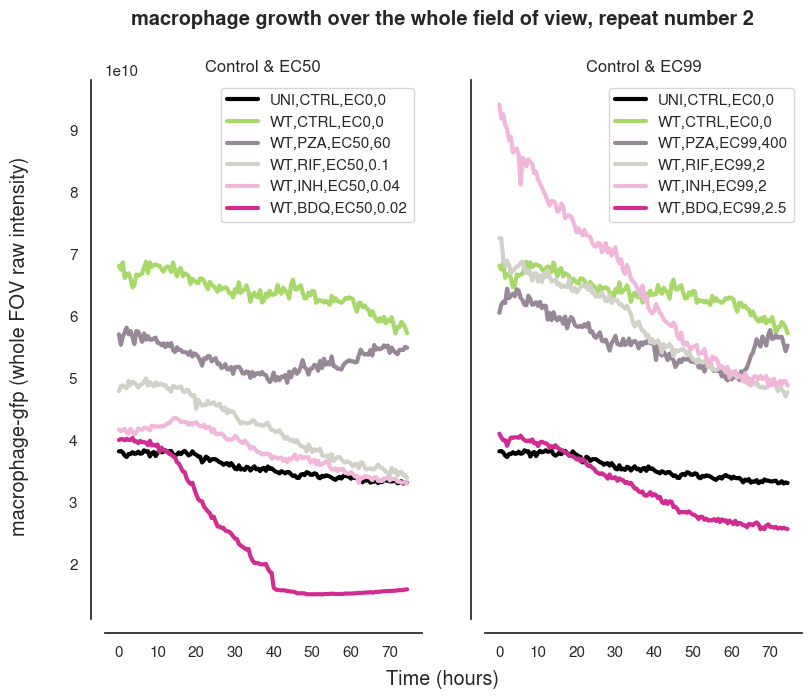

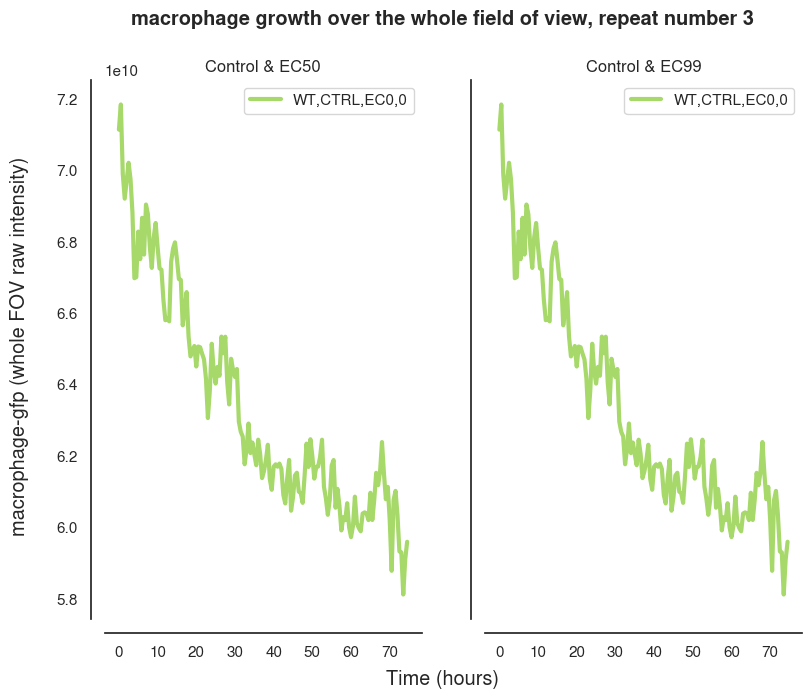

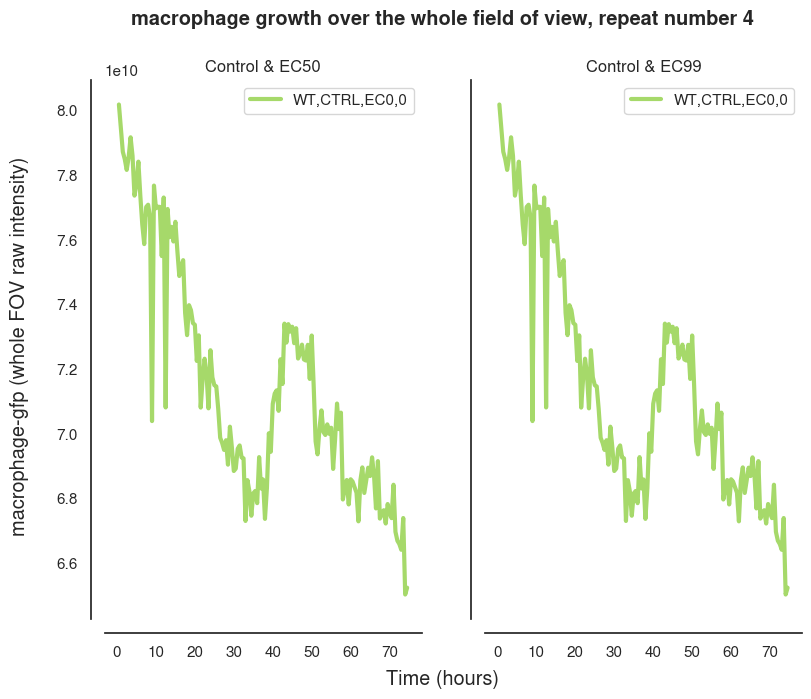

In [37]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
    x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
    plt.suptitle(f'macrophage growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1219171/1471896642.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/1471896642.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/1471896642.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/1471896642.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


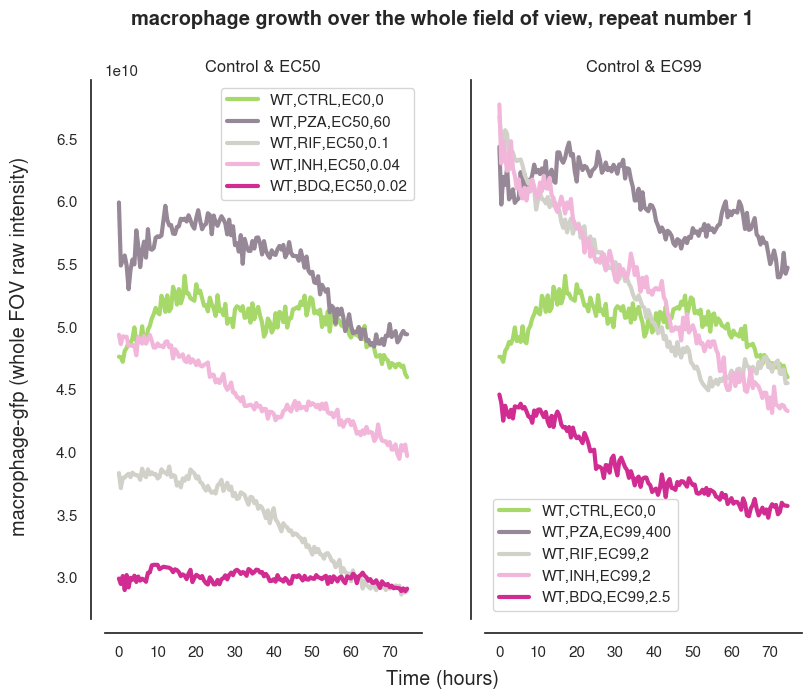

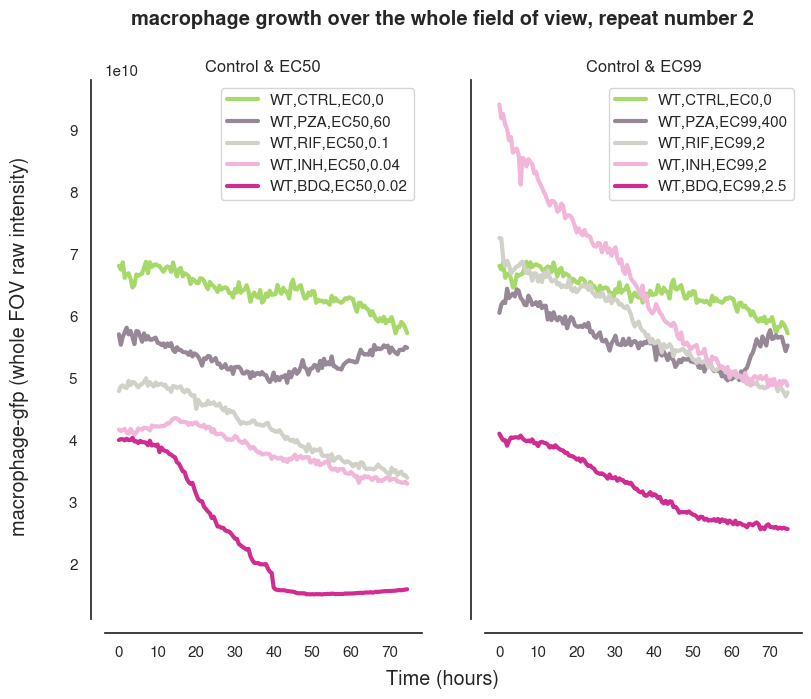

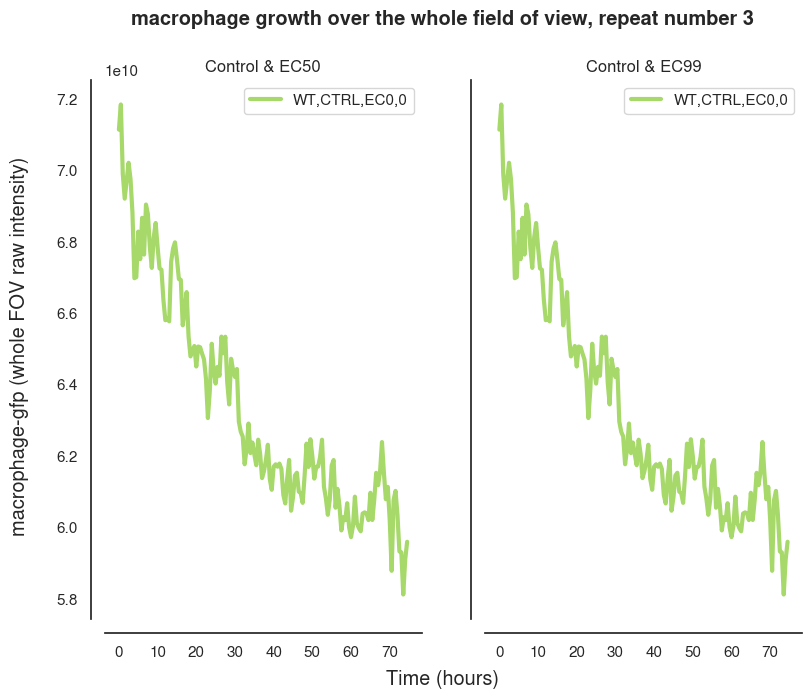

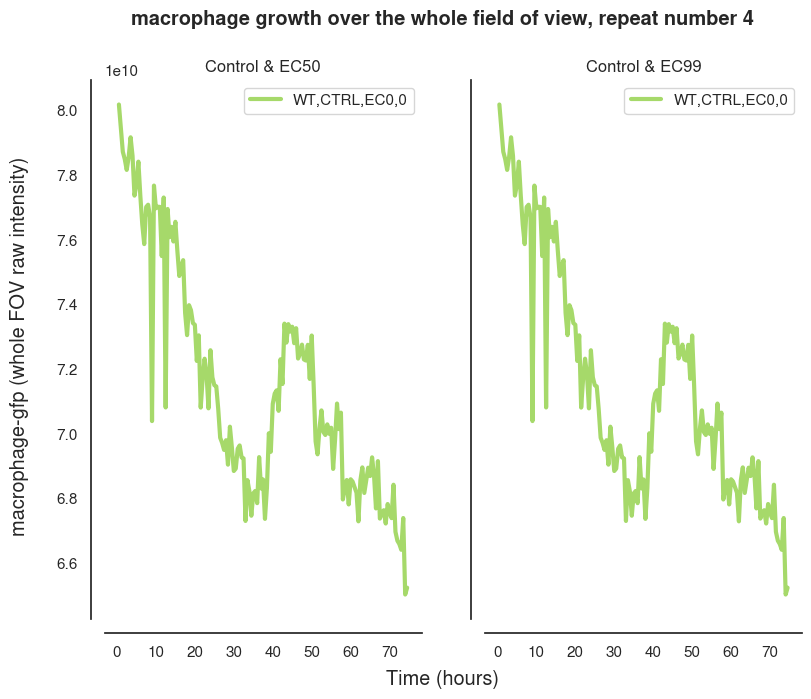

In [38]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
    x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
    plt.suptitle(f'macrophage growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_wo_uni_word1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1219171/949445440.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/949445440.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/949445440.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1219171/949445440.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


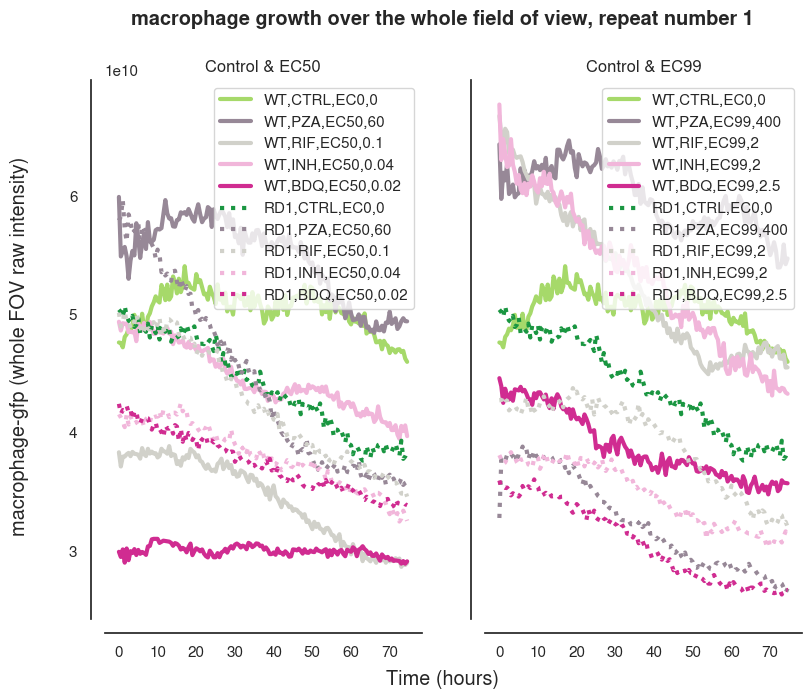

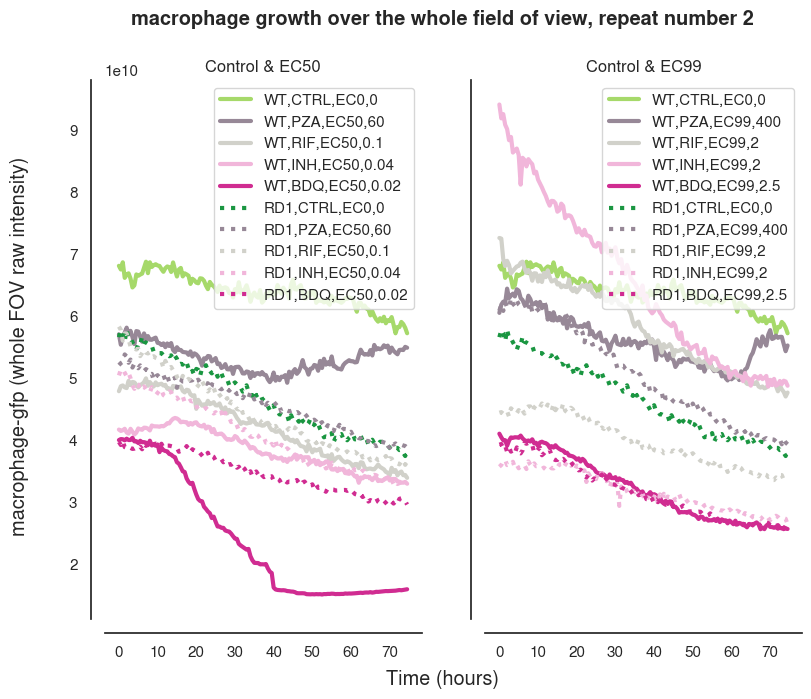

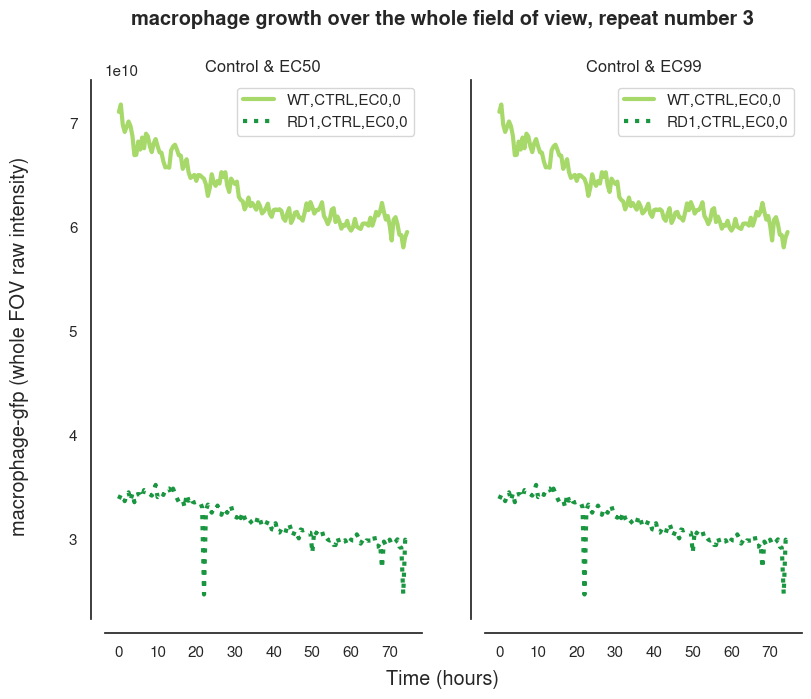

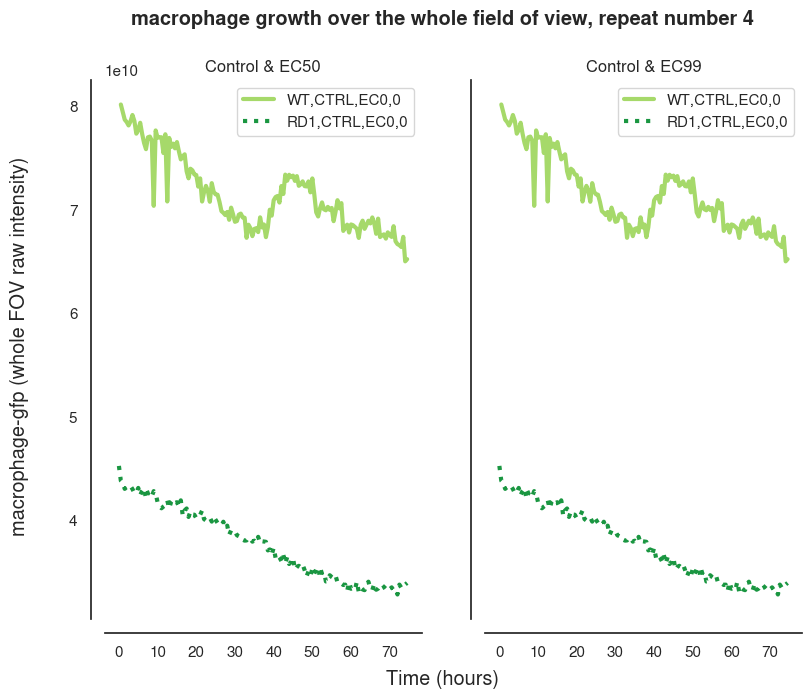

In [39]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
    x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
    plt.suptitle(f'macrophage growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_wo_uni_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



### Plotting repeats overlaid

/tmp/ipykernel_1219171/2103661602.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


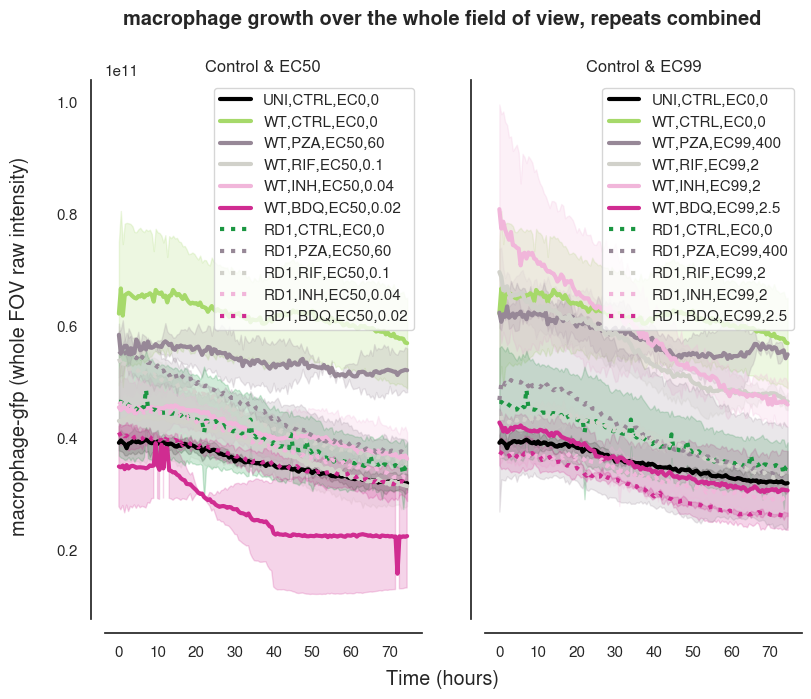

In [40]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
plt.suptitle(f'macrophage growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_atbs_combined.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1219171/1058140453.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


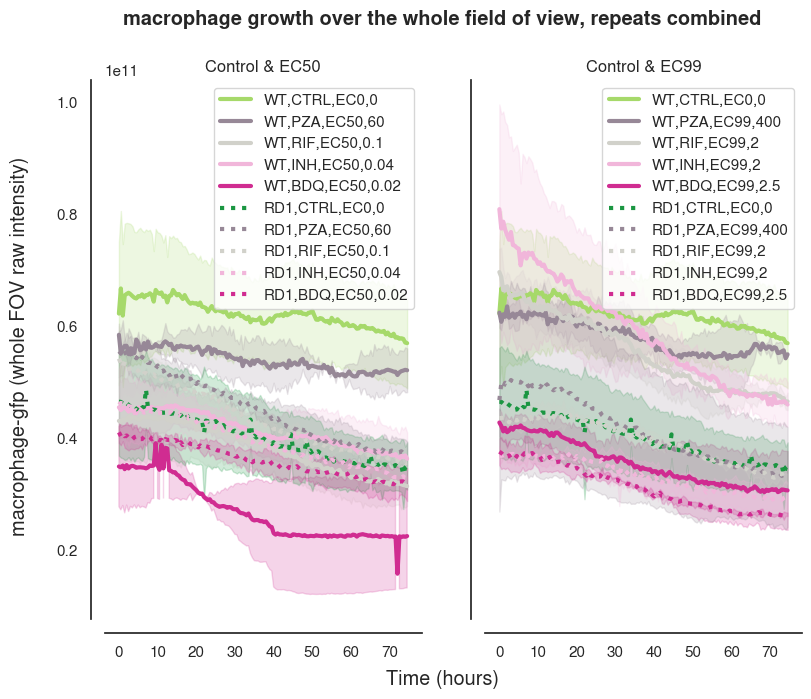

In [41]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
plt.suptitle(f'macrophage growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_atbs_combined_wo_uni.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1219171/4156814071.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


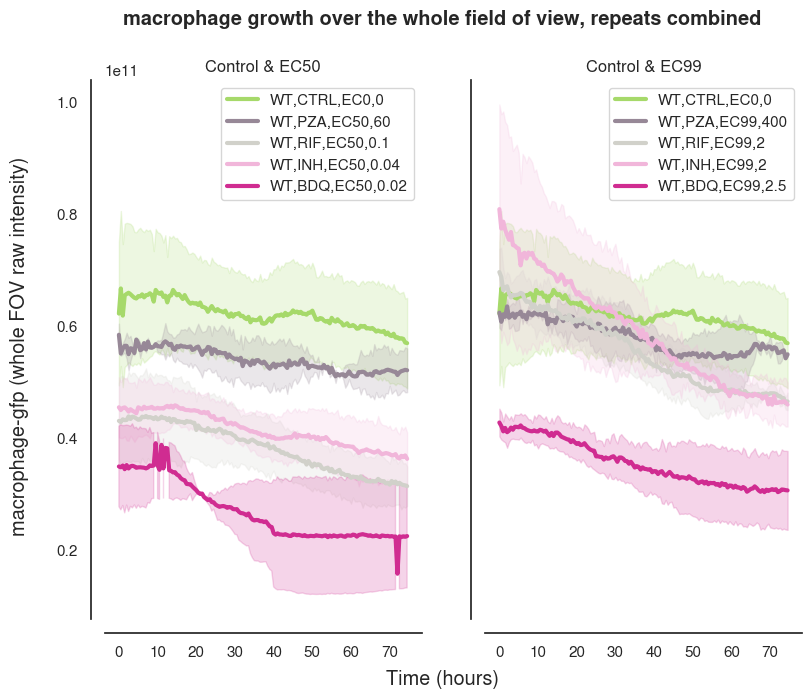

In [42]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI', 'RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
plt.suptitle(f'macrophage growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_atbs_combined_wo_uni_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1219171/2023409096.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


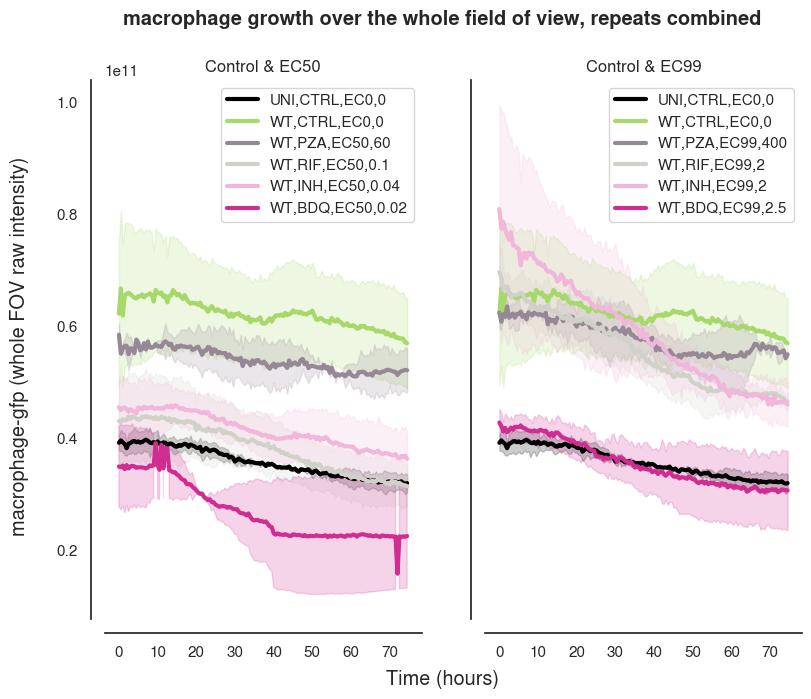

In [43]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(gfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(gfp_df.T.columns))]
x_ticks = range(0, len(gfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('macrophage-gfp (whole FOV raw intensity)')
plt.suptitle(f'macrophage growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_macrophage_growth_atbs_combined_wo_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()



In [45]:
for i in range(1000):
    notify('fml', 'missing u already jurgen')